In [1]:
%matplotlib inline

import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas
from sklearn.metrics import roc_auc_score
from numpy import fft
from numpy.random import randint
from collections import deque
import sys
sys.setrecursionlimit(10000)
import cPickle as pickle

# Lasagne (& friends) imports
import theano
from nolearn.lasagne import BatchIterator, NeuralNet
from lasagne.objectives import aggregate
from lasagne.objectives import binary_crossentropy
from lasagne.layers import InputLayer, DropoutLayer, DenseLayer,Conv1DLayer, Conv2DLayer, MaxPool1DLayer
from lasagne.updates import nesterov_momentum
from theano.tensor.nnet import sigmoid

# Silence some warnings from lasagne
import warnings
warnings.filterwarnings('ignore', '.*topo.*')
warnings.filterwarnings('ignore', module='.*lasagne.init.*')
warnings.filterwarnings('ignore', module='.*nolearn.lasagne.*')

Using gpu device 0: Quadro K2000


In [2]:
SUBJECTS = list(range(1,13))
TRAIN_SERIES = list(range(1,9))
TEST_SERIES = [9,10]

N_ELECTRODES = 32
N_EVENTS = 6

# We train on TRAIN_SIZE randomly selected location each "epoch" (yes, that's
# not really an epoch). One-fifth of these locations are used for validation,
# hence the 5*X format, to make it clear what the number of validation points
# is.
TRAIN_SIZE = 5*1024

# We encapsulate the event / electrode data in a Source object. 

class Source:

    mean = None
    std = None

    def load_raw_data(self, subject, series):
        raw_data = [self.read_csv(self.path(subject, i, "data")) for i in series]
        self.data = np.concatenate(raw_data, axis=0)
        raw_events = [self.read_csv(self.path(subject, i, "events")) for i in series]
        self.events = np.concatenate(raw_events, axis=0)
    
    def normalize(self):
        self.data -= self.mean
        self.data /= self.std
        
    @staticmethod
    def path(subject, series, kind):
        prefix = "train" if (series in TRAIN_SERIES) else "test"
        return "input/{0}/subj{1}_series{2}_{3}.csv".format(prefix, subject, series, kind)
    
    @staticmethod
    def read_csv(path):
        return pandas.read_csv(path, index_col=0).values
            
        
class TrainSource(Source):

    def __init__(self, subject, series_list):
        self.load_raw_data(subject, series_list)
        self.mean = self.data.mean(axis=0)
        self.std = self.data.std(axis=0)
        self.normalize()
        self.principle_components = scipy.linalg.svd(self.data, full_matrices=False)
        self.std2 = self.data.std(axis=0)
        self.data /= self.std2

        
# Note that Test/Submit sources use the mean/std from the training data.
# This is both standard practice and avoids using future data in theano
# test set.
        
class TestSource(Source):

    def __init__(self, subject, series, train_source):
        self.load_raw_data(subject, series)
        self.mean = train_source.mean
        self.std = train_source.std
        self.principle_components = train_source.principle_components
        self.normalize()
        self.data /= train_source.std2
        

class SubmitSource(TestSource):

    def __init__(self, subject, a_series, train_source):
        TestSource.__init__(self, subject, [a_series], train_source)

    def load_raw_data(self, subject, series):
        [a_series] = series
        self.data = self.read_csv(self.path(subject, a_series, "data"))

In [3]:
# Lay out the Neural net.

class LayerFactory:
    """Helper class that makes laying out Lasagne layers more pleasant"""
    def __init__(self):
        self.layer_cnt = 0
        self.kwargs = {}
    def __call__(self, layer, layer_name=None, **kwargs):
        self.layer_cnt += 1
        name = layer_name or "layer{0}".format(self.layer_cnt)
        for k, v in kwargs.items():
            self.kwargs["{0}_{1}".format(name, k)] = v
        return (name, layer) 


SAMPLE_SIZE = 4000 # Larger (2048 perhaps) would be better
DOWNSAMPLE = 8
TIME_POINTS = SAMPLE_SIZE // DOWNSAMPLE
    
class IndexBatchIterator(BatchIterator):
    """Generate BatchData from indices.
    
    Rather than passing the data into the fit function, instead we just pass in indices to
    the data.  The actual data is then grabbed from a Source object that is passed in at
    the creation of the IndexBatchIterator. Passing in a '-1' grabs a random value from
    the Source.
    
    As a result, an "epoch" here isn't a traditional epoch, which looks at all the
    time points. Instead a random subsamle of 0.8*TRAIN_SIZE points from the
    training data are used each "epoch" and 0.2 TRAIN_SIZE points are uses for
    validation.

    """
    def __init__(self, source, *args, **kwargs):
        super(IndexBatchIterator, self).__init__(*args, **kwargs)
        self.source = source
        if source is not None:
            # Tack on (SAMPLE_SIZE-1) copies of the first value so that it is easy to grab
            # SAMPLE_SIZE POINTS even from the first location.
            x = source.data
            self.augmented = np.zeros([len(x)+(SAMPLE_SIZE-1), N_ELECTRODES], dtype=np.float32)
            self.augmented[SAMPLE_SIZE-1:] = x
            self.augmented[:SAMPLE_SIZE-1] = x[0]
        self.Xbuf = np.zeros([self.batch_size, N_ELECTRODES, TIME_POINTS], np.float32) 
        self.Ybuf = np.zeros([self.batch_size, N_EVENTS], np.float32) 
    
    def transform(self, X_indices, y_indices):
        X_indices, y_indices = super(IndexBatchIterator, self).transform(X_indices, y_indices)
        [count] = X_indices.shape
        # Use preallocated space
        X = self.Xbuf[:count]
        Y = self.Ybuf[:count]
        for i, ndx in enumerate(X_indices):
            if ndx == -1:
                ndx = np.random.randint(len(self.source.events))
            sample = self.augmented[ndx:ndx+SAMPLE_SIZE]
            # Reverse so we get most recent point, otherwise downsampling drops the last
            # DOWNSAMPLE-1 points.
            X[i] = sample[::-1][::DOWNSAMPLE].transpose()
            if y_indices is not None:
                Y[i] = self.source.events[ndx]
        Y = None if (y_indices is None) else Y
        return X, Y
    

# Simple / Naive net. Borrows from Daniel Nouri's Facial Keypoint Detection Tutorial 
    
def create_net1(train_source, test_source, batch_size=128, max_epochs=20): 
    
    batch_iter_train = IndexBatchIterator(train_source, batch_size=batch_size)
    batch_iter_test  = IndexBatchIterator(test_source, batch_size=batch_size)
    LF = LayerFactory()

    dense = 1024 # larger (1024 perhaps) would be better
    
    layers = [
        LF(InputLayer, layer_name='input', shape=(None, N_ELECTRODES, TIME_POINTS)), 
#        LF(InputLayer, shape=(None, N_ELECTRODES, TIME_POINTS)), 
        LF(DropoutLayer, layer_name='Dropout1', p=0.5),
        # This first layer condenses N_ELECTRODES down to num_filters.
        # Since the electrode results are reportedly highly reduntant this
        # should speed things up without sacrificing accuracy. It may
        # also increase stability.
        LF(Conv1DLayer, layer_name='Conv1', num_filters=8, filter_size=1),
        # Standard fully connected net from now on
        LF(DenseLayer, layer_name='Dense1', num_units=dense),
        LF(DropoutLayer, layer_name='Dropout2', p=0.5),
        LF(DenseLayer, layer_name='Dense2', num_units=dense),
        LF(DropoutLayer, layer_name='Dropout3', p=0.5),
        LF(DenseLayer, layer_name="output", num_units=N_EVENTS, nonlinearity=sigmoid)
    ]
    
    def loss(x,t):
        return aggregate(binary_crossentropy(x, t))
    
    
    nnet =  NeuralNet(
        y_tensor_type = theano.tensor.matrix,
        layers = layers,
        batch_iterator_train = batch_iter_train,
        batch_iterator_test = batch_iter_test,
        max_epochs=max_epochs,
        verbose=1,
        update = nesterov_momentum, 
        update_learning_rate = 0.02,
        update_momentum = 0.9,
        objective_loss_function = loss,
        regression = True,
        **LF.kwargs
        )

    return nnet

In [4]:
tseries = sorted(set(TRAIN_SERIES) - set([1,2]))
train_source = TrainSource(1, tseries)
test_source = TestSource(1, [1,2], train_source)


([array([ 381250.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,   10200.]),
  array([ 381250.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,   10200.]),
  array([ 381250.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,   10200.]),
  array([ 381250.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,   10200.]),
  array([ 381250.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,   10200.]),
  array([ 381250.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,   10200.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 6 Lists of Patches objects>)

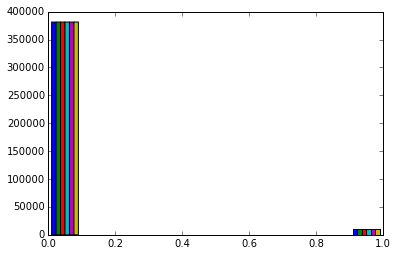

In [8]:
plt.hist(test_source.events)

In [21]:
# Sample size 4000
if __name__ == "__main__":
    train_info = train_all(create_net1, max_epochs=100) # Training for longer would be better (> 40 epochs)
    make_submission(train_info, "naive_grasp.csv")

('Subject:', 1)
  input             	(None, 32, 500)     	produces   16000 outputs
  layer2            	(None, 32, 500)     	produces   16000 outputs
  layer3            	(None, 8, 500)      	produces    4000 outputs
  layer4            	(None, 1024)        	produces    1024 outputs
  layer5            	(None, 1024)        	produces    1024 outputs
  layer6            	(None, 1024)        	produces    1024 outputs
  layer7            	(None, 1024)        	produces    1024 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.21816       0.16693      1.30688  1.81s
      2       0.14047       0.19029      0.73816  1.77s
      3       0.13770       0.16903      0.81467  1.77s
      4       0.13450       0.18784      0.71603  1.76s
      5       0.13686       0.16208      0.84441  1.77s
      6       0.12946       0.16449      0.78707  1.77s
  

In [5]:
class EarlyStopping(object):
    def __init__(self, patience=100, running_avg=5):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None
        
        last_values = np.empty(running_avg)
        last_values[:] = np.inf
        self.last_values = deque(last_values)

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        
        self.last_values.append(current_valid)
        self.last_values.popleft()
        
        current_mean_valid = np.mean(list(self.last_values))
        #print('Last values %s with mean value %s' %(self.last_values,np.mean(list(self.last_values))) )
        
        if current_mean_valid < self.best_valid:
            print('Best last values %s with mean value %s' %(self.last_values, current_mean_valid) )
            self.best_valid = current_mean_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

def create_net2(train_source, test_source, batch_size=128, max_epochs=20): 
    
    batch_iter_train = IndexBatchIterator(train_source, batch_size=batch_size)
    batch_iter_test  = IndexBatchIterator(test_source, batch_size=batch_size)
    LF = LayerFactory()

    dense = 1024 # larger (1024 perhaps) would be better
    
    layers = [
        LF(InputLayer, layer_name='input', shape=(None, N_ELECTRODES, TIME_POINTS)), 
#        LF(InputLayer, shape=(None, N_ELECTRODES, TIME_POINTS)), 
        LF(DropoutLayer, layer_name='Dropout1', p=0.5),
        # This first layer condenses N_ELECTRODES down to num_filters.
        # Since the electrode results are reportedly highly reduntant this
        # should speed things up without sacrificing accuracy. It may
        # also increase stability.
        LF(Conv1DLayer, layer_name='Conv1', num_filters=8, filter_size=1),
        # Standard fully connected net from now on
        LF(DenseLayer, layer_name='Dense1', num_units=dense),
        LF(DropoutLayer, layer_name='Dropout2', p=0.5),
        LF(DenseLayer, layer_name='Dense2', num_units=dense),
        LF(DropoutLayer, layer_name='Dropout3', p=0.5),
        LF(DenseLayer, layer_name="output", num_units=N_EVENTS, nonlinearity=sigmoid)
    ]
    
    def loss(x,t):
        return aggregate(binary_crossentropy(x, t))
    
    
    nnet =  NeuralNet(
        y_tensor_type = theano.tensor.matrix,
        layers = layers,
        batch_iterator_train = batch_iter_train,
        batch_iterator_test = batch_iter_test,
        max_epochs=max_epochs,
        verbose=1,
        update = nesterov_momentum, 
        update_learning_rate = 0.02,
        update_momentum = 0.9,
        objective_loss_function = loss,
        regression = True,
        on_epoch_finished=[
        EarlyStopping(patience=100, running_avg=10),
        ],
        **LF.kwargs
        )

    return nnet

('Subject:', 4)
  input             	(None, 32, 4000)    	produces  128000 outputs
  Dropout1          	(None, 32, 4000)    	produces  128000 outputs
  Conv1             	(None, 8, 4000)     	produces   32000 outputs
  Dense1            	(None, 1024)        	produces    1024 outputs
  Dropout2          	(None, 1024)        	produces    1024 outputs
  Dense2            	(None, 1024)        	produces    1024 outputs
  Dropout3          	(None, 1024)        	produces    1024 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  ------
      1       0.21268       0.10453      2.03471  10.54s
      2       0.16162       0.10858      1.48857  10.29s
      3       0.13983       0.08819      1.58554  10.27s
      4       0.14123       0.09135      1.54602  10.41s
      5       0.12604       0.08770      1.43718  10.44s
      6       0.12319       0.11446      1.07628  10

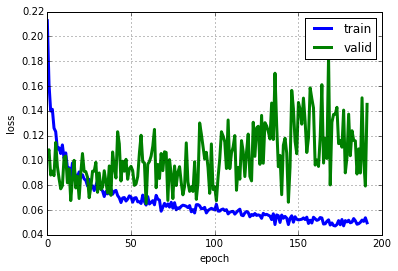

('Subject:', 5)
  input             	(None, 32, 4000)    	produces  128000 outputs
  Dropout1          	(None, 32, 4000)    	produces  128000 outputs
  Conv1             	(None, 8, 4000)     	produces   32000 outputs
  Dense1            	(None, 1024)        	produces    1024 outputs
  Dropout2          	(None, 1024)        	produces    1024 outputs
  Dense2            	(None, 1024)        	produces    1024 outputs
  Dropout3          	(None, 1024)        	produces    1024 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  ------
      1       0.19248       0.13243      1.45348  10.60s
      2       0.13558       0.12491      1.08541  10.57s
      3       0.14146       0.14012      1.00953  10.51s
      4       0.12594       0.13754      0.91566  10.21s
      5       0.12887       0.17007      0.75776  10.24s
      6       0.12062       0.16161      0.74637  10

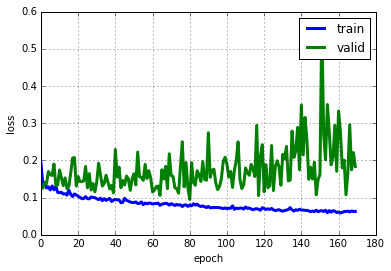

('Subject:', 6)
  input             	(None, 32, 4000)    	produces  128000 outputs
  Dropout1          	(None, 32, 4000)    	produces  128000 outputs
  Conv1             	(None, 8, 4000)     	produces   32000 outputs
  Dense1            	(None, 1024)        	produces    1024 outputs
  Dropout2          	(None, 1024)        	produces    1024 outputs
  Dense2            	(None, 1024)        	produces    1024 outputs
  Dropout3          	(None, 1024)        	produces    1024 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  ------
      1       0.18753       0.14445      1.29821  10.03s
      2       0.13962       0.16187      0.86253  9.98s
      3       0.13209       0.17259      0.76537  9.97s
      4       0.12862       0.16782      0.76641  9.98s
      5       0.11109       0.15062      0.73756  10.78s
      6       0.11007       0.13285      0.82848  10.42

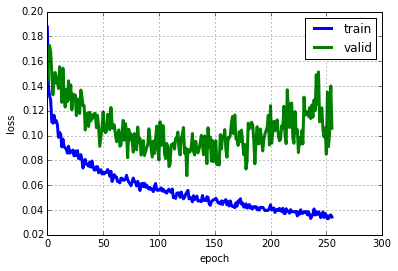

('Subject:', 4, ', series:', 9)
  input             	(None, 32, 4000)    	produces  128000 outputs
  Dropout1          	(None, 32, 4000)    	produces  128000 outputs
  Conv1             	(None, 8, 4000)     	produces   32000 outputs
  Dense1            	(None, 1024)        	produces    1024 outputs
  Dropout2          	(None, 1024)        	produces    1024 outputs
  Dense2            	(None, 1024)        	produces    1024 outputs
  Dropout3          	(None, 1024)        	produces    1024 outputs
  output            	(None, 6)           	produces       6 outputs
('Subject:', 4, ', series:', 10)
  input             	(None, 32, 4000)    	produces  128000 outputs
  Dropout1          	(None, 32, 4000)    	produces  128000 outputs
  Conv1             	(None, 8, 4000)     	produces   32000 outputs
  Dense1            	(None, 1024)        	produces    1024 outputs
  Dropout2          	(None, 1024)        	produces    1024 outputs
  Dense2            	(None, 1024)        	produces    1024 outpu

In [65]:
# Sample size 4000, max_epoch = 400, early stopping, 1x downsampling
# Split into two runs
if __name__ == "__main__":
    #train_info = train_all(create_net2, max_epochs=400) # Training for longer would be better (> 40 epochs)
    #make_submission(train_info, "nnet2.csv")
    
    score_file = 'nnet2_scores.csv'
    
    #train_info_1 = train_subset(create_net2, range(1,4), score_file=score_file, max_epochs=400)
    #submit_subset(train_info_1, subset, "nnet2_1.csv" )

    subset = range(4,7)
    train_info_2 = train_subset(create_net2, subset, score_file=score_file, max_epochs=400)
    submit_subset(train_info_2, subset, "nnet2_2.csv" )
    
    #subset = range(7,10)
    #train_info_3 = train_subset(create_net2, subset, score_file=score_file, max_epochs=400)
    #submit_subset(train_info_3, subset, "nnet2_3.csv" )
    
    #subset = range(10,13)
    #train_info_4 = train_subset(create_net2, subset, score_file=score_file, max_epochs=400)
    #submit_subset(train_info_4, subset, "nnet2_4.csv" )

In [8]:
# Do the training.

train_indices = np.zeros([TRAIN_SIZE], dtype=int) - 1


def score(net, samples=256):
    """Compute the area under the curve, ROC score
    
    We take `samples` random samples and compute the ROC AUC
    score on those samples. 
    """
    source = net.batch_iterator_test.source
    test_indices = np.arange(len(source.events))
    np.random.seed(199)
    np.random.shuffle(test_indices)
    predicted = net.predict_proba(test_indices[:samples])
    actual = source.events[test_indices[:samples]]
    return roc_auc_score(actual.reshape(-1), predicted.reshape(-1))
    

def train(factory, subj, max_epochs=20, valid_series=[1,2]):
    tseries = sorted(set(TRAIN_SERIES) - set(valid_series))
    # tseries = sorted(set([6,7]) - set(valid_series))
    train_source = TrainSource(subj, tseries)
    test_source = TestSource(subj, valid_series, train_source)
    net = factory(train_source, test_source, max_epochs=max_epochs)
    net.fit(train_indices, train_indices)
    print("Score:", score(net))
    return (net, train_source)
 
def plot_training(net): 
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    plt.plot(train_loss, linewidth=3, label="train")
    plt.plot(valid_loss, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    #plt.ylim(1e-3, 1e-2)
    #plt.yscale("log")
    plt.show()
    
    
def train_all(factory, score_file='current_score.csv', max_epochs=20, valid_series=[1,2]):
    info = {}
    for subj in SUBJECTS:
        print("Subject:", subj)
        
        net, train_source = train(factory, subj, max_epochs, valid_series)
        
        with open(score_file, 'a') as file:
            file.write(('%s,%s' % (subj, score(net)) ))
            file.write('\n')
        
        plot_training(net)
        
        info[subj] = (net, train_source)
    return (factory, info)   

def train_subset(factory, subjects, score_file='current_score.csv', max_epochs=20, valid_series=[1,2]):
    info = {}
    for subj in subjects:
        print("Subject:", subj)
        
        net, train_source = train(factory, subj, max_epochs, valid_series)
        
        #pickle_file = ('%s_net2.pickle' % (subj))
        #with open(('%s _net2.pickle') % subj , 'wb') as f:
            #pickle.dump(net, f, -1)
        
        with open(score_file, 'a') as file:
            file.write(('%s,%s' % (subj, score(net)) ))
            file.write('\n')
        
        plot_training(net)
        
        info[subj] = (net, train_source)
    return (factory, info)   

 
def make_submission(train_info, name):
    factory, info = train_info
    lines = ["id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased"]
    for subj in SUBJECTS:
        weights, train_source = info[subj]
        for series in [9,10]:
            print("Subject:", subj, ", series:", series)
            submit_source = SubmitSource(subj, series, train_source)  
            indices = np.arange(len(submit_source.data))
            net = factory(train_source=None, test_source=submit_source)
            net.load_weights_from(weights)
            probs = net.predict_proba(indices)
            for i, p in enumerate(probs):
                id = "subj{0}_series{1}_{2},".format(subj, series, i)
                lines.append(id + ",".join(str(x) for x in p))
    with open(name, 'w') as file:
        file.write("\n".join(lines))

def submit_subset(train_info, subset, name, header=True):
    factory, info = train_info
    if(header):
        lines = ["id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased"]
    else: 
        lines = ""

    for subj in subset:
        weights, train_source = info[subj]
        for series in [9,10]:
            print("Subject:", subj, ", series:", series)
            submit_source = SubmitSource(subj, series, train_source)  
            indices = np.arange(len(submit_source.data))
            net = factory(train_source=None, test_source=submit_source)
            net.load_weights_from(weights)
            probs = net.predict_proba(indices)
            for i, p in enumerate(probs):
                id = "subj{0}_series{1}_{2},".format(subj, series, i)
                lines.append(id + ",".join(str(x) for x in p))
    with open(name, 'w') as file:
        file.write("\n".join(lines))

In [14]:
def create_net3(train_source, test_source, batch_size=128, max_epochs=20): 
    
    batch_iter_train = IndexBatchIterator(train_source, batch_size=batch_size)
    batch_iter_test  = IndexBatchIterator(test_source, batch_size=batch_size)
    LF = LayerFactory()

    dense = 512 # larger (1024 perhaps) would be better
    
    layers = [
        LF(InputLayer, layer_name='input', shape=(None, N_ELECTRODES, TIME_POINTS)), 
#        LF(InputLayer, shape=(None, N_ELECTRODES, TIME_POINTS)), 

        # This first layer condenses N_ELECTRODES down to num_filters.
        # Since the electrode results are reportedly highly reduntant this
        # should speed things up without sacrificing accuracy. It may
        # also increase stability.
        LF(DropoutLayer, layer_name='Dropout0', p=0.5),
        LF(Conv1DLayer, layer_name='Conv1', num_filters=32, filter_size=3),
        LF(MaxPool1DLayer, layer_name='Pool1', pool_size=2),
        LF(DropoutLayer, layer_name='Dropout1', p=0.5),
        
        LF(Conv1DLayer, layer_name='Conv2', num_filters=16, filter_size=2),
        LF(MaxPool1DLayer, layer_name='Pool2', pool_size=2),
        LF(DropoutLayer, layer_name='Dropout2', p=0.5),
        
        LF(Conv1DLayer, layer_name='Conv3', num_filters=8, filter_size=1),
        LF(DropoutLayer, layer_name='Dropout3', p=0.5),
#        
        # Standard fully connected net from now on
        LF(DenseLayer, layer_name='Dense4', num_units=dense),
        LF(DropoutLayer, layer_name='Dropout4', p=0.5),
        LF(DenseLayer, layer_name='Dense5', num_units=dense),
        LF(DropoutLayer, layer_name='Dropout5', p=0.5),
        LF(DenseLayer, layer_name="output", num_units=N_EVENTS, nonlinearity=sigmoid)
    ]
    
    def loss(x,t):
        return aggregate(binary_crossentropy(x, t))
    
    
    nnet =  NeuralNet(
        y_tensor_type = theano.tensor.matrix,
        layers = layers,
        batch_iterator_train = batch_iter_train,
        batch_iterator_test = batch_iter_test,
        max_epochs=max_epochs,
        verbose=1,
        update = nesterov_momentum, 
        update_learning_rate = 0.02,
        update_momentum = 0.9,
        objective_loss_function = loss,
        regression = True,
        on_epoch_finished=[
        EarlyStopping(patience=100, running_avg=10),
        ],
        **LF.kwargs
        )

    return nnet

('Subject:', 1)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.21654       0.21937      0.98708  1.43s
      2       0.14359       0.20505      0.70025  1.40s
      3       0.13582       0.20031      0.67805  1.40s
      4       0.13534       0.20774      0.65150  1.40s
      5       0.12566       0.16059      0.78248  1.40s
      6       0.13762       0.16263      0.84621  1.40s
  

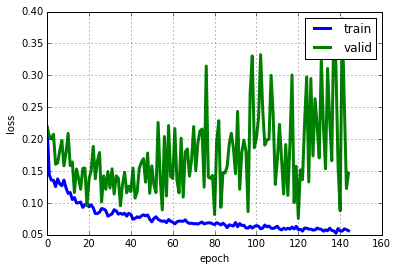

('Subject:', 2)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.20640       0.09808      2.10444  1.50s
      2       0.13754       0.08646      1.59079  1.49s
      3       0.13875       0.08801      1.57658  1.57s
      4       0.12898       0.08777      1.46949  1.58s
      5       0.13526       0.09501      1.42368  1.58s
      6       0.12454       0.10293      1.20995  1.58s
  

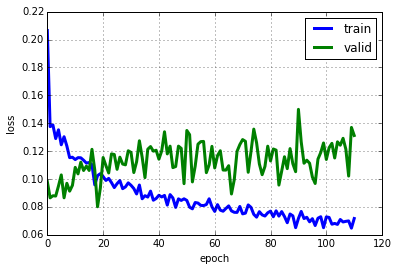

('Subject:', 3)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.20758       0.22769      0.91169  1.44s
      2       0.14055       0.20918      0.67190  1.39s
      3       0.14458       0.20063      0.72065  1.40s
      4       0.15435       0.22576      0.68370  1.39s
      5       0.15103       0.21476      0.70324  1.40s
      6       0.13516       0.22520      0.60017  1.47s
  

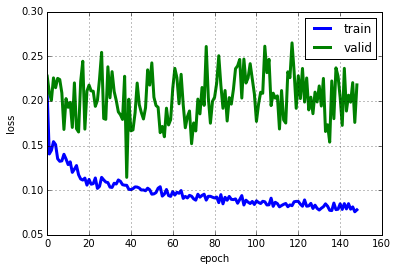

('Subject:', 4)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.25449       0.12101      2.10299  1.55s
      2       0.17086       0.11775      1.45104  1.57s
      3       0.17695       0.12063      1.46690  1.57s
      4       0.15622       0.11529      1.35502  1.57s
      5       0.15427       0.11453      1.34706  1.57s
      6       0.13999       0.11010      1.27145  1.57s
  

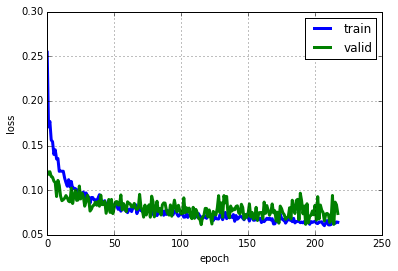

('Subject:', 5)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.21214       0.15233      1.39264  1.45s
      2       0.13609       0.13304      1.02293  1.51s
      3       0.13230       0.14229      0.92979  1.53s
      4       0.12867       0.18534      0.69425  1.53s
      5       0.13367       0.12417      1.07655  1.49s
      6       0.13293       0.17418      0.76314  1.42s
  

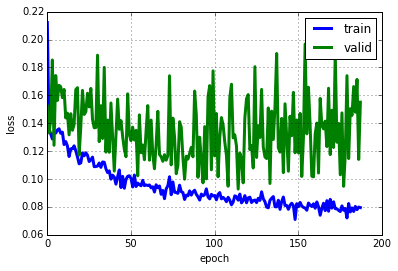

('Subject:', 6)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.21043       0.17032      1.23549  1.56s
      2       0.13724       0.14799      0.92735  1.40s
      3       0.14128       0.16794      0.84127  1.40s
      4       0.12420       0.15147      0.82002  1.40s
      5       0.12572       0.15962      0.78763  1.40s
      6       0.13604       0.16889      0.80551  1.40s
  

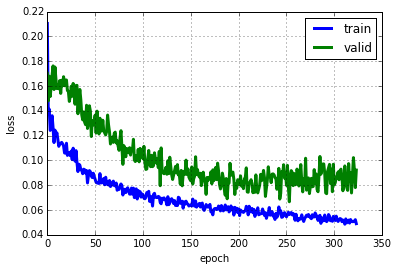

('Subject:', 7)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.19664       0.18474      1.06440  1.43s
      2       0.13696       0.15153      0.90381  1.40s
      3       0.12849       0.15137      0.84887  1.40s
      4       0.12769       0.14930      0.85524  1.40s
      5       0.12616       0.15073      0.83696  1.40s
      6       0.12225       0.14822      0.82480  1.40s
  

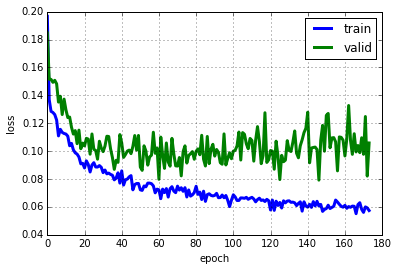

('Subject:', 8)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.23713       0.16745      1.41613  1.47s
      2       0.17026       0.16379      1.03949  1.44s
      3       0.15497       0.16851      0.91965  1.43s
      4       0.16357       0.16342      1.00093  1.44s
      5       0.14885       0.15837      0.93988  1.45s
      6       0.15070       0.16355      0.92143  1.40s
  

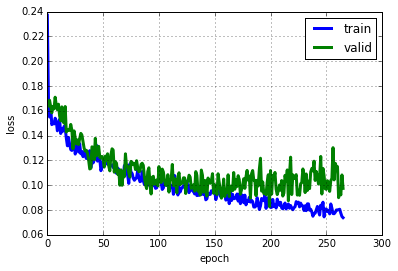

('Subject:', 9)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.22531       0.17689      1.27378  1.44s
      2       0.15262       0.15608      0.97784  1.42s
      3       0.14292       0.15857      0.90129  1.42s
      4       0.13737       0.16437      0.83571  1.42s
      5       0.13964       0.15294      0.91303  1.42s
      6       0.13672       0.15096      0.90565  1.42s
  

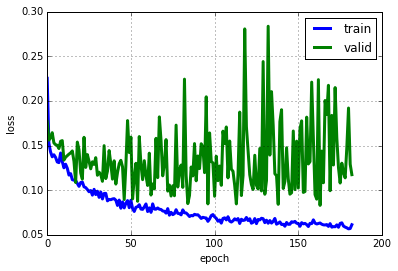

('Subject:', 10)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.20778       0.14346      1.44833  1.50s
      2       0.15323       0.10807      1.41789  1.40s
      3       0.14333       0.10855      1.32040  1.41s
      4       0.14778       0.11333      1.30396  1.40s
      5       0.14161       0.10949      1.29334  1.40s
      6       0.13157       0.11896      1.10607  1.40s
 

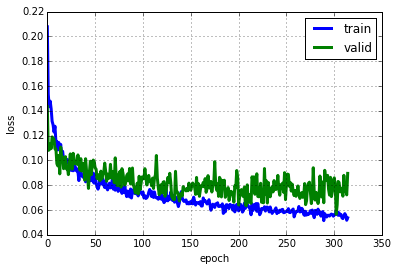

('Subject:', 11)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.20921       0.13978      1.49669  1.42s
      2       0.14462       0.13819      1.04653  1.40s
      3       0.13497       0.13958      0.96694  1.40s
      4       0.13517       0.12464      1.08447  1.58s
      5       0.13582       0.14235      0.95414  1.58s
      6       0.12972       0.12108      1.07132  1.42s
 

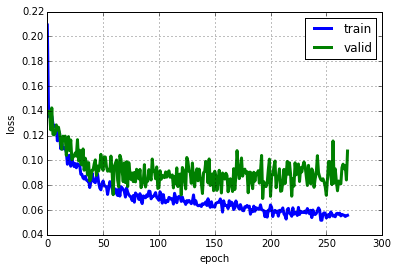

('Subject:', 12)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.21695       0.17006      1.27571  1.53s
      2       0.13181       0.15084      0.87383  1.46s
      3       0.12775       0.14918      0.85633  1.47s
      4       0.11922       0.14797      0.80567  1.42s
      5       0.12502       0.13790      0.90658  1.41s
      6       0.11631       0.15455      0.75262  1.43s
 

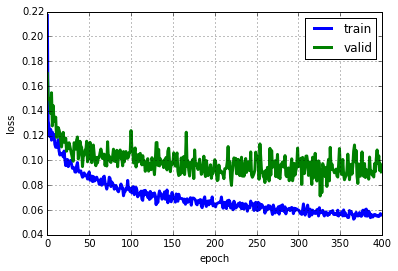

('Subject:', 1, ', series:', 9)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
('Subject:', 1, ', series:', 10)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout1          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 8, 500)      	produces    4000 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outpu

KeyboardInterrupt: 

In [97]:
# Sample size 4000
if __name__ == "__main__":
    train_info = train_all(create_net3, score_file='nnet3_scores.csv', max_epochs=1000)
    make_submission(train_info, "nnet3.csv")

In [ ]:
# Second drop out layer after convolution layer
# Sample size 4000
if __name__ == "__main__":
    train_info = train_all(create_net3, score_file='nnet3_scores.csv', max_epochs=1000)
    make_submission(train_info, "nnet3.csv")

('Subject:', 1)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.22771       0.28974      0.78591  6.29s
      2       0.14022       0.25012      0.56063  6.28s
      3       0.14040    

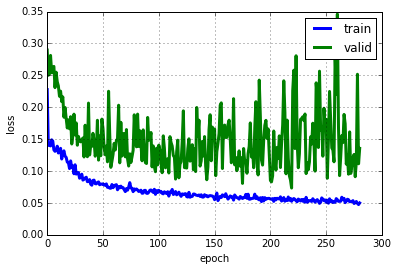

('Subject:', 2)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.19339       0.11397      1.69685  6.30s
      2       0.14548       0.11618      1.25212  6.31s
      3       0.13835    

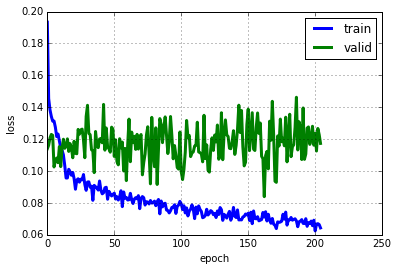

('Subject:', 3)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.23116       0.24733      0.93462  6.19s
      2       0.14802       0.26239      0.56411  6.18s
      3       0.14157    

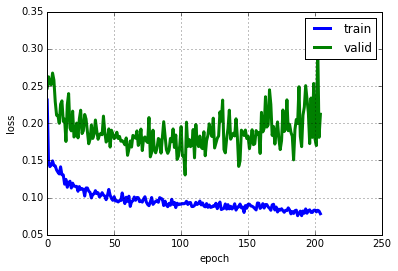

('Subject:', 4)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.23802       0.24127      0.98651  6.19s
      2       0.16312       0.21447      0.76058  6.18s
      3       0.16327    

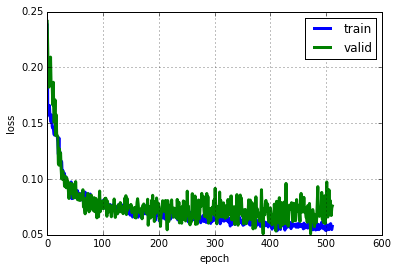

('Subject:', 5)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.20780       0.21019      0.98860  6.19s
      2       0.14150       0.23285      0.60769  6.18s
      3       0.13758    

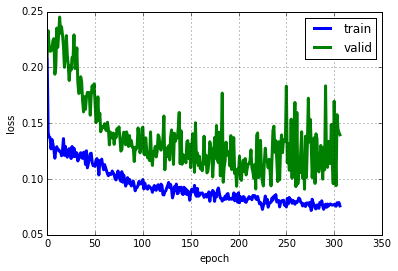

('Subject:', 6)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.20532       0.30297      0.67771  6.19s
      2       0.14115       0.30801      0.45828  6.19s
      3       0.14333    

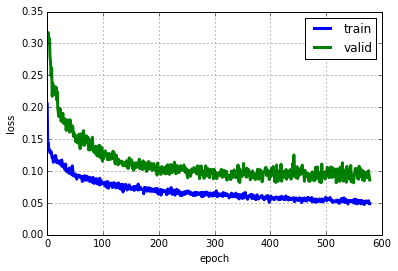

('Subject:', 7)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.19203       0.36945      0.51978  6.19s
      2       0.12719       0.31665      0.40167  6.18s
      3       0.12635    

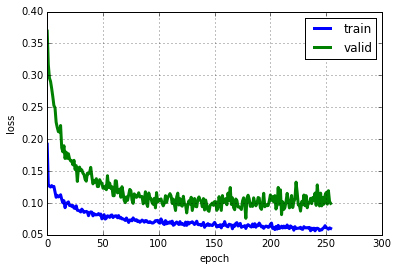

('Subject:', 8)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.24424       0.35774      0.68273  6.19s
      2       0.15365       0.35585      0.43178  6.18s
      3       0.16726    

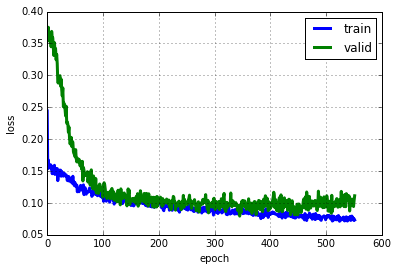

('Subject:', 9)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.19173       0.26629      0.72002  6.20s
      2       0.15507       0.26560      0.58386  6.19s
      3       0.12997    

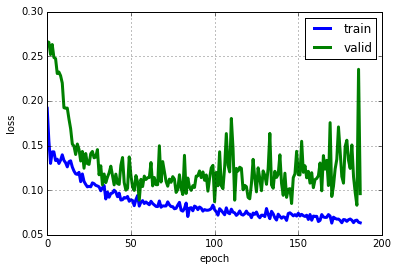

('Subject:', 10)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.21933       0.27879      0.78674  6.22s
      2       0.14550       0.31323      0.46453  6.19s
      3       0.14782   

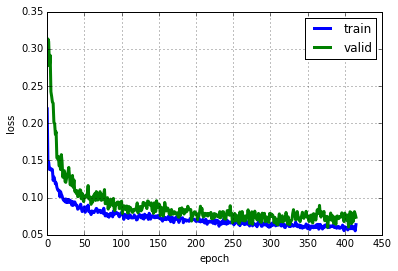

('Subject:', 11)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.20971       0.31262      0.67081  6.20s
      2       0.12909       0.27229      0.47410  6.18s
      3       0.13285   

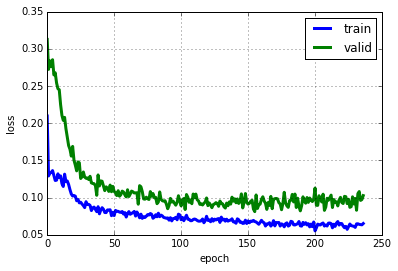

('Subject:', 12)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.20999       0.43005      0.48829  6.19s
      2       0.12532       0.39061      0.32082  6.18s
      3       0.13077   

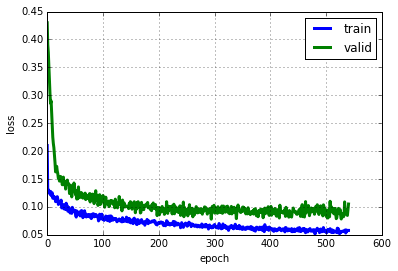

('Subject:', 1, ', series:', 9)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 8, 249)      	produces    1992 outputs
  Dense1            	(None, 512)         	produces     512 outputs
  Dropout2          	(None, 512)         	produces     512 outputs
  Dense2            	(None, 512)         	produces     512 outputs
  Dropout3          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	produces       6 outputs
('Subject:', 1, ', series:', 10)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outpu

In [7]:
# Add convolution layer with 32 x 3 and 8 x 1 
#        LF(DropoutLayer, layer_name='Dropout0', p=0.5),
#        LF(Conv1DLayer, layer_name='Conv1', num_filters=32, filter_size=3),
#        LF(MaxPool1DLayer, layer_name='Pool1', pool_size=2),
#       LF(DropoutLayer, layer_name='Dropout1', p=0.5),
#        LF(Conv1DLayer, layer_name='Conv2', num_filters=8, filter_size=1),

if __name__ == "__main__":
    train_info = train_all(create_net3, score_file='nnet3_scores.csv', max_epochs=1000)
    make_submission(train_info, "nnet3.csv")

('Subject:', 1)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 16, 248)     	produces    3968 outputs
  Pool2             	(None, 16, 124)     	produces    1984 outputs
  Dropout2          	(None, 16, 124)     	produces    1984 outputs
  Conv3             	(None, 8, 124)      	produces     992 outputs
  Dropout3          	(None, 8, 124)      	produces     992 outputs
  Dense4            	(None, 512)         	produces     512 outputs
  Dropout4          	(None, 512)         	produces     512 outputs
  Dense5            	(None, 512)         	produces     512 outputs
  Dropout5          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	prod

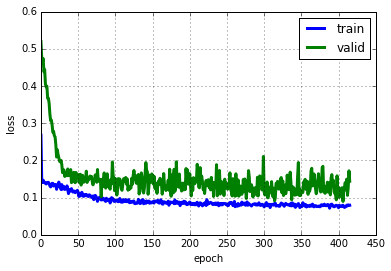

('Subject:', 2)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 16, 248)     	produces    3968 outputs
  Pool2             	(None, 16, 124)     	produces    1984 outputs
  Dropout2          	(None, 16, 124)     	produces    1984 outputs
  Conv3             	(None, 8, 124)      	produces     992 outputs
  Dropout3          	(None, 8, 124)      	produces     992 outputs
  Dense4            	(None, 512)         	produces     512 outputs
  Dropout4          	(None, 512)         	produces     512 outputs
  Dense5            	(None, 512)         	produces     512 outputs
  Dropout5          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	prod

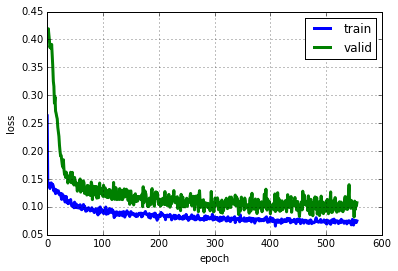

('Subject:', 3)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 16, 248)     	produces    3968 outputs
  Pool2             	(None, 16, 124)     	produces    1984 outputs
  Dropout2          	(None, 16, 124)     	produces    1984 outputs
  Conv3             	(None, 8, 124)      	produces     992 outputs
  Dropout3          	(None, 8, 124)      	produces     992 outputs
  Dense4            	(None, 512)         	produces     512 outputs
  Dropout4          	(None, 512)         	produces     512 outputs
  Dense5            	(None, 512)         	produces     512 outputs
  Dropout5          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	prod

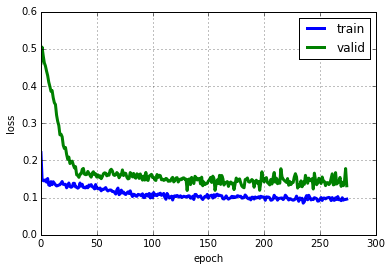

('Subject:', 4)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 16, 248)     	produces    3968 outputs
  Pool2             	(None, 16, 124)     	produces    1984 outputs
  Dropout2          	(None, 16, 124)     	produces    1984 outputs
  Conv3             	(None, 8, 124)      	produces     992 outputs
  Dropout3          	(None, 8, 124)      	produces     992 outputs
  Dense4            	(None, 512)         	produces     512 outputs
  Dropout4          	(None, 512)         	produces     512 outputs
  Dense5            	(None, 512)         	produces     512 outputs
  Dropout5          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	prod

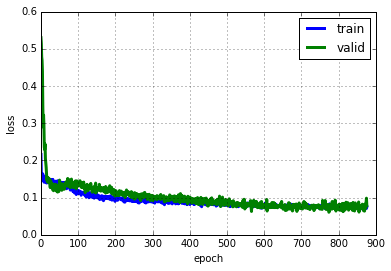

('Subject:', 5)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 16, 248)     	produces    3968 outputs
  Pool2             	(None, 16, 124)     	produces    1984 outputs
  Dropout2          	(None, 16, 124)     	produces    1984 outputs
  Conv3             	(None, 8, 124)      	produces     992 outputs
  Dropout3          	(None, 8, 124)      	produces     992 outputs
  Dense4            	(None, 512)         	produces     512 outputs
  Dropout4          	(None, 512)         	produces     512 outputs
  Dense5            	(None, 512)         	produces     512 outputs
  Dropout5          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	prod

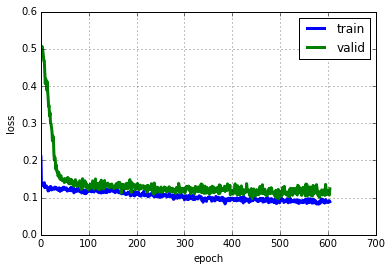

('Subject:', 6)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 16, 248)     	produces    3968 outputs
  Pool2             	(None, 16, 124)     	produces    1984 outputs
  Dropout2          	(None, 16, 124)     	produces    1984 outputs
  Conv3             	(None, 8, 124)      	produces     992 outputs
  Dropout3          	(None, 8, 124)      	produces     992 outputs
  Dense4            	(None, 512)         	produces     512 outputs
  Dropout4          	(None, 512)         	produces     512 outputs
  Dense5            	(None, 512)         	produces     512 outputs
  Dropout5          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	prod

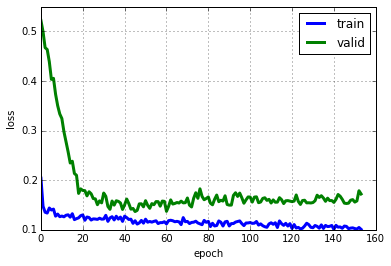

('Subject:', 7)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 16, 248)     	produces    3968 outputs
  Pool2             	(None, 16, 124)     	produces    1984 outputs
  Dropout2          	(None, 16, 124)     	produces    1984 outputs
  Conv3             	(None, 8, 124)      	produces     992 outputs
  Dropout3          	(None, 8, 124)      	produces     992 outputs
  Dense4            	(None, 512)         	produces     512 outputs
  Dropout4          	(None, 512)         	produces     512 outputs
  Dense5            	(None, 512)         	produces     512 outputs
  Dropout5          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	prod

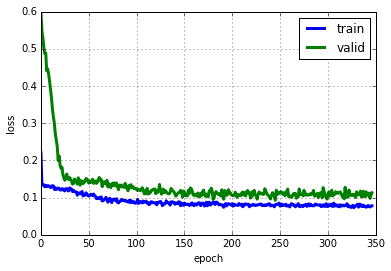

('Subject:', 8)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 16, 248)     	produces    3968 outputs
  Pool2             	(None, 16, 124)     	produces    1984 outputs
  Dropout2          	(None, 16, 124)     	produces    1984 outputs
  Conv3             	(None, 8, 124)      	produces     992 outputs
  Dropout3          	(None, 8, 124)      	produces     992 outputs
  Dense4            	(None, 512)         	produces     512 outputs
  Dropout4          	(None, 512)         	produces     512 outputs
  Dense5            	(None, 512)         	produces     512 outputs
  Dropout5          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	prod

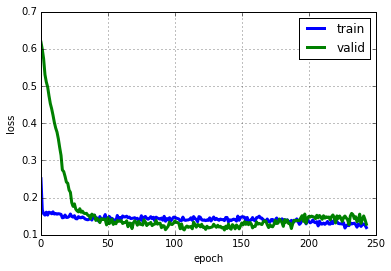

('Subject:', 9)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 16, 248)     	produces    3968 outputs
  Pool2             	(None, 16, 124)     	produces    1984 outputs
  Dropout2          	(None, 16, 124)     	produces    1984 outputs
  Conv3             	(None, 8, 124)      	produces     992 outputs
  Dropout3          	(None, 8, 124)      	produces     992 outputs
  Dense4            	(None, 512)         	produces     512 outputs
  Dropout4          	(None, 512)         	produces     512 outputs
  Dense5            	(None, 512)         	produces     512 outputs
  Dropout5          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	prod

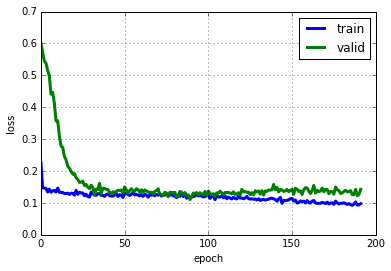

('Subject:', 10)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 16, 248)     	produces    3968 outputs
  Pool2             	(None, 16, 124)     	produces    1984 outputs
  Dropout2          	(None, 16, 124)     	produces    1984 outputs
  Conv3             	(None, 8, 124)      	produces     992 outputs
  Dropout3          	(None, 8, 124)      	produces     992 outputs
  Dense4            	(None, 512)         	produces     512 outputs
  Dropout4          	(None, 512)         	produces     512 outputs
  Dense5            	(None, 512)         	produces     512 outputs
  Dropout5          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	pro

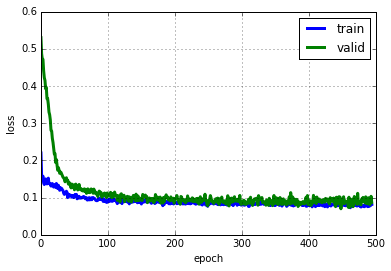

('Subject:', 11)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 16, 248)     	produces    3968 outputs
  Pool2             	(None, 16, 124)     	produces    1984 outputs
  Dropout2          	(None, 16, 124)     	produces    1984 outputs
  Conv3             	(None, 8, 124)      	produces     992 outputs
  Dropout3          	(None, 8, 124)      	produces     992 outputs
  Dense4            	(None, 512)         	produces     512 outputs
  Dropout4          	(None, 512)         	produces     512 outputs
  Dense5            	(None, 512)         	produces     512 outputs
  Dropout5          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	pro

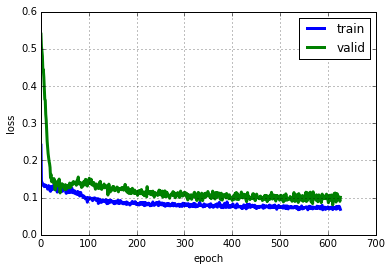

('Subject:', 12)
  input             	(None, 32, 500)     	produces   16000 outputs
  Dropout0          	(None, 32, 500)     	produces   16000 outputs
  Conv1             	(None, 32, 498)     	produces   15936 outputs
  Pool1             	(None, 32, 249)     	produces    7968 outputs
  Dropout1          	(None, 32, 249)     	produces    7968 outputs
  Conv2             	(None, 16, 248)     	produces    3968 outputs
  Pool2             	(None, 16, 124)     	produces    1984 outputs
  Dropout2          	(None, 16, 124)     	produces    1984 outputs
  Conv3             	(None, 8, 124)      	produces     992 outputs
  Dropout3          	(None, 8, 124)      	produces     992 outputs
  Dense4            	(None, 512)         	produces     512 outputs
  Dropout4          	(None, 512)         	produces     512 outputs
  Dense5            	(None, 512)         	produces     512 outputs
  Dropout5          	(None, 512)         	produces     512 outputs
  output            	(None, 6)           	pro

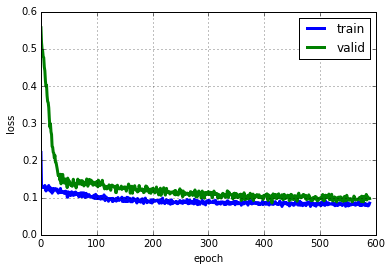

('Subject:', 1, ', series:', 9)


KeyboardInterrupt: 

In [15]:
# Add convolution layer with 64 x 3, 32 x 2 and 8 x 1 
#LF(DropoutLayer, layer_name='Dropout0', p=0.5),
#LF(Conv1DLayer, layer_name='Conv1', num_filters=64, filter_size=3),
#LF(MaxPool1DLayer, layer_name='Pool1', pool_size=2),
#LF(DropoutLayer, layer_name='Dropout1', p=0.1),
        
#LF(Conv1DLayer, layer_name='Conv2', num_filters=32, filter_size=2),
#LF(MaxPool1DLayer, layer_name='Pool2', pool_size=2),
#LF(DropoutLayer, layer_name='Dropout2', p=0.3),
        
#LF(Conv1DLayer, layer_name='Conv3', num_filters=8, filter_size=1),
#LF(DropoutLayer, layer_name='Dropout3', p=0.5),
if __name__ == "__main__":
    train_info = train_all(create_net3, score_file='nnet4_scores.csv', max_epochs=1000)
    make_submission(train_info, "nnet4.csv")